In [1]:
# importing libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

C:\Users\Pranay Singla\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
# load data
ml_df = pd.read_csv('data/ML.csv')
ml_tag = pd.read_csv('data/MLtag.csv')
p = 0.1
synthentic_df = pd.read_csv('data/Synthetic_Financial_Datasets.csv', nrows=1_00_000, skiprows=lambda i: i>0 and random.random() > p)

In [44]:
synthentic_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,5031.22,C247113419,0.00,0.00,M151442075,0.0,0.0,0,0
1,1,PAYMENT,7413.54,C1470868839,297689.58,290276.03,M1426725223,0.0,0.0,0,0
2,1,PAYMENT,9164.71,C1458621573,47235.77,38071.06,M1658980982,0.0,0.0,0,0
3,1,PAYMENT,6440.78,C1161148117,2192.00,0.00,M516875052,0.0,0.0,0,0
4,1,TRANSFER,17231.46,C1243171897,0.00,0.00,C783286238,24672.0,0.0,0,0


In [19]:
synthentic_df.drop(['isFlaggedFraud'], axis=1, inplace=True)

In [20]:
synthentic_df['date'] = synthentic_df['step'].apply(lambda x: pd.to_datetime('2019-02-20') + pd.offsets.Day(x))

In [21]:
mapper = {
    'type': 'typeofaction',
    'nameOrig': 'sourceid',
    'nameDest': 'destinationid',
    'amount': 'amountofmoney',
    'date': 'date',
    'isFraud': 'isfraud',
}

clean_df = synthentic_df.rename(columns = mapper)

In [22]:
clean_df = clean_df[mapper.values()]

In [23]:
clean_df['typeoffraud'] = clean_df['isfraud'].apply(lambda x: f'type{random.randint(1, 2)}' if x == 1 else 'none')

In [24]:
ml_df.typeofaction.replace({
    'transfer': 'TRANSFER',
    'cash-in': 'CASH_IN'
}, inplace=True)

In [25]:
clean_df.head()

,typeofaction,sourceid,destinationid,amountofmoney,date,isfraud,typeoffraud
0,PAYMENT,C2048537720,M1230701703,11668.14,2019-02-21,0,none
1,PAYMENT,C154988899,M408069119,7107.77,2019-02-21,0,none
2,PAYMENT,C923341586,M107994825,2791.42,2019-02-21,0,none
3,PAYMENT,C1481594086,M1569435561,1684.81,2019-02-21,0,none
4,PAYMENT,C484199463,M2008106788,13875.98,2019-02-21,0,none


In [26]:
ml_df.head()

,typeofaction,sourceid,destinationid,amountofmoney,date,isfraud,typeoffraud
0,CASH_IN,30105,28942,494528,2019-07-19 14:40:00,1,type1
1,CASH_IN,30105,8692,494528,2019-05-17 14:57:00,1,type1
2,CASH_IN,30105,60094,494528,2019-07-20 13:20:00,1,type1
3,CASH_IN,30105,20575,494528,2019-07-03 14:15:00,1,type1
4,CASH_IN,30105,45938,494528,2019-05-26 10:40:00,1,type1


In [27]:
main_df = pd.concat([clean_df, ml_df], axis=0)

In [28]:
main_df.head()

,typeofaction,sourceid,destinationid,amountofmoney,date,isfraud,typeoffraud
0,PAYMENT,C2048537720,M1230701703,11668.14,2019-02-21 00:00:00,0,none
1,PAYMENT,C154988899,M408069119,7107.77,2019-02-21 00:00:00,0,none
2,PAYMENT,C923341586,M107994825,2791.42,2019-02-21 00:00:00,0,none
3,PAYMENT,C1481594086,M1569435561,1684.81,2019-02-21 00:00:00,0,none
4,PAYMENT,C484199463,M2008106788,13875.98,2019-02-21 00:00:00,0,none


In [29]:
def one_hot(df, key='typeofaction'):
    return pd.concat([
            main_df,
            pd.get_dummies(main_df[key], prefix=key, drop_first=True)
        ], axis=1)

In [30]:
main_df = one_hot(main_df)

In [31]:
main_df.drop('typeofaction', axis=1, inplace=True)
main_df.head()

,sourceid,destinationid,amountofmoney,date,isfraud,typeoffraud,typeofaction_CASH_OUT,typeofaction_DEBIT,typeofaction_PAYMENT,typeofaction_TRANSFER
0,C2048537720,M1230701703,11668.14,2019-02-21 00:00:00,0,none,0,0,1,0
1,C154988899,M408069119,7107.77,2019-02-21 00:00:00,0,none,0,0,1,0
2,C923341586,M107994825,2791.42,2019-02-21 00:00:00,0,none,0,0,1,0
3,C1481594086,M1569435561,1684.81,2019-02-21 00:00:00,0,none,0,0,1,0
4,C484199463,M2008106788,13875.98,2019-02-21 00:00:00,0,none,0,0,1,0


In [32]:
main_df = main_df.reset_index(drop=True)
main_df[['sourceid', 'destinationid']] = main_df[['sourceid', 'destinationid']].astype(str)

In [33]:
main_df['date'] = pd.to_datetime(main_df['date'])

In [34]:
main_df.to_pickle("main_df.pkl")

## Start from here if you have a pickled file

In [3]:
main_df = pd.read_pickle('main_df.pkl')

In [4]:
main_df.groupby(['date','isfraud']).size()

date                 isfraud
2019-02-20 10:23:00  1          1
2019-02-20 13:04:00  0          1
2019-02-20 13:29:00  0          1
2019-02-20 14:09:00  0          1
2019-02-20 14:45:00  0          1
                               ..
2019-07-20 10:30:00  0          1
2019-07-20 13:11:00  1          1
2019-07-20 13:12:00  1          1
2019-07-20 13:20:00  1          1
2019-07-20 14:33:00  0          1
Length: 2396, dtype: int64

In [5]:
main_df.drop('typeoffraud', axis=1, inplace=True)

In [6]:
# main_df = one_hot(main_df, 'sourceid')
# main_df = one_hot(main_df, 'destinationid')

# drop col
# main_df.drop(['destinationid', 'sourceid'], axis=1, inplace=True)

In [7]:
main_df['prefix_source'] = main_df['sourceid'].str[:1]
main_df['prefix_destination'] = main_df['destinationid'].str[:1]

In [8]:
main_df.head()

,sourceid,destinationid,amountofmoney,date,isfraud,typeofaction_CASH_OUT,typeofaction_DEBIT,typeofaction_PAYMENT,typeofaction_TRANSFER,prefix_source,prefix_destination
0,C2048537720,M1230701703,11668.14,2019-02-21,0,0,0,1,0,C,M
1,C154988899,M408069119,7107.77,2019-02-21,0,0,0,1,0,C,M
2,C923341586,M107994825,2791.42,2019-02-21,0,0,0,1,0,C,M
3,C1481594086,M1569435561,1684.81,2019-02-21,0,0,0,1,0,C,M
4,C484199463,M2008106788,13875.98,2019-02-21,0,0,0,1,0,C,M


In [9]:
def create_datetime_features(df, col, time_params_reqd = False, remove_main_date=False, prefix='temp'):
    """
    Function to extract features from the datetime column and return the df with the updated values

    Example:
    create_datetime_features(portfoliostats[['BookedDate']], 'BookedDate', prefix='bookedDate', remove_main_date=True)
    """
    if df[col].dtype != 'datetime64[ns]':
        df[col] = pd.to_datetime(df[col]) 
        
    df[f'{prefix}_year'] = df[col].dt.year
    df[f'{prefix}_month'] = df[col].dt.month
    df[f'{prefix}_day'] = df[col].dt.day
    df[f'{prefix}_week'] = df[col].dt.week
    df[f'{prefix}_dayofweek'] = df[col].dt.dayofweek
    df[f'{prefix}_isweekend'] = (df[col].dt.dayofweek >=5).astype(int)
    df[f'{prefix}_isWeekday'] = (df[col].dt.dayofweek < 5).astype(int)
    df[f'{prefix}_dayofyear'] = df[col].dt.dayofyear
    df[f'{prefix}_quarter'] = df[col].dt.quarter
    df[f'{prefix}_isleapyear'] = df[col].dt.is_leap_year.astype(int)
    df[f'{prefix}_monthDifferenceFromToday'] = (datetime.datetime.today() - df[col]).dt.days//30
    df[f'{prefix}_dayDifferenceFromToday'] = (datetime.datetime.today() - df[col]).dt.days

    if time_params_reqd:
        df[f'{prefix}_hour'] = df[col].dt.hour
        df[f'{prefix}_minute'] = df[col].dt.minute

    if remove_main_date:
        df.drop([col], axis=1, inplace=True)
    
    return df

In [52]:
main_df = main_df.sort_values('date')

In [53]:
main_df['date_lag'] = main_df.groupby('sourceid')['date'].shift(1)
main_df['date_lag'].fillna(pd.to_datetime('2019-02-13'), inplace=True)
main_df['days_since_last_transaction'] = (main_df['date'] - main_df['date_lag']).dt.days
main_df['hours_since_last_transaction'] = \
((main_df['date'] - main_df['date_lag']).dt.days) * 24 + ((main_df['date'] - main_df['date_lag']).dt.seconds) // 3600
# main_df['mins_since_last_transaction'] = (((main_df['date'] - main_df['date_lag']).dt.seconds) % 3600) //60

In [54]:
main_df = create_datetime_features(main_df, 'date', True, False)

In [55]:
def one_hot_2(df, key):
    return pd.concat([
            df,
            pd.get_dummies(df[key], prefix=key, drop_first=True)
        ], axis=1)

In [56]:
# main_df = one_hot_2(main_df, 'prefix_source')
main_df = one_hot_2(main_df, 'prefix_destination')
main_df = one_hot_2(main_df, 'temp_month')
main_df = one_hot_2(main_df, 'temp_day')
main_df = one_hot_2(main_df, 'temp_week')
main_df = one_hot_2(main_df, 'temp_dayofweek')
main_df = one_hot_2(main_df, 'temp_quarter')

In [57]:
main_df.drop(['destinationid', 'sourceid', 'date', 'temp_minute', 'temp_monthDifferenceFromToday', 
             'temp_dayDifferenceFromToday', 'date_lag', 'temp_year', 'temp_dayofyear', 'prefix_source',
             'prefix_destination', 'temp_month', 'temp_day', 'temp_week', 'temp_dayofweek', 'temp_quarter', 'temp_hour'],
             axis=1, inplace=True, errors='ignore')

In [58]:
# pd.options.display.max_columns = None

In [59]:
main_df.reset_index(drop=True, inplace=True)

In [81]:
main_df.head()

,amountofmoney,isfraud,typeofaction_CASH_OUT,typeofaction_DEBIT,typeofaction_PAYMENT,typeofaction_TRANSFER,days_since_last_transaction,hours_since_last_transaction,temp_isweekend,temp_isWeekday,...,temp_week_28,temp_week_29,temp_dayofweek_1,temp_dayofweek_2,temp_dayofweek_3,temp_dayofweek_4,temp_dayofweek_5,temp_dayofweek_6,temp_quarter_2,temp_quarter_3
0,288350.0,1,0,0,0,1,7,178,0,1,...,0,0,0,1,0,0,0,0,0,0
1,3217217.0,0,0,0,0,1,7,181,0,1,...,0,0,0,1,0,0,0,0,0,0
2,328738.0,0,0,0,0,0,7,181,0,1,...,0,0,0,1,0,0,0,0,0,0
3,3083463.0,0,0,0,0,1,7,182,0,1,...,0,0,0,1,0,0,0,0,0,0
4,3316517.0,0,0,0,0,0,7,182,0,1,...,0,0,0,1,0,0,0,0,0,0


In [82]:
main_df.to_pickle('final_df.pkl')

In [83]:
main_df.groupby('isfraud').size()

isfraud
0    100880
1      1460
dtype: int64

In [10]:
main_df = pd.read_pickle('final_df.pkl')

## Modeling

### DecisionTree

In [11]:
X = main_df.loc[:,main_df.columns != 'isfraud']
y = main_df.loc[:, 'isfraud']

In [12]:
# Stratified split of the train and test set with train-test ratio of 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                            stratify=y, random_state=10)

In [13]:
def display_summary(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    print('confusion matrix')
    print(np.array([[tp,fp],[fn,tn]]))
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))

In [14]:
clf_tree = tree.DecisionTreeClassifier(max_depth=3, random_state= 33)
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
print('Decision Tree')
display_summary(y_test,y_pred_tree)

Decision Tree
confusion matrix
[[  229     9]
 [  209 30255]]
sensitivity is %f 0.5228310502283106
specificity is %f 0.9997026169706582
accuracy is %f 0.9928994853755456
balanced accuracy is % 0.7612668335994843


In [15]:
roc_auc_score(y_test, y_pred_tree)

0.7612668335994843

In [16]:
# std = np.std([clf_tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
importances = clf_tree.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#         color="r", align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()

Feature ranking:
1. feature 0 (0.509242)
2. feature 5 (0.239210)
3. feature 6 (0.188206)
4. feature 4 (0.062767)
5. feature 18 (0.000576)
6. feature 31 (0.000000)
7. feature 24 (0.000000)
8. feature 25 (0.000000)
9. feature 26 (0.000000)
10. feature 27 (0.000000)
11. feature 28 (0.000000)
12. feature 29 (0.000000)
13. feature 30 (0.000000)
14. feature 33 (0.000000)
15. feature 32 (0.000000)
16. feature 22 (0.000000)
17. feature 34 (0.000000)
18. feature 35 (0.000000)
19. feature 36 (0.000000)
20. feature 37 (0.000000)
21. feature 38 (0.000000)
22. feature 39 (0.000000)
23. feature 23 (0.000000)
24. feature 20 (0.000000)
25. feature 21 (0.000000)
26. feature 82 (0.000000)
27. feature 1 (0.000000)
28. feature 2 (0.000000)
29. feature 3 (0.000000)
30. feature 7 (0.000000)
31. feature 8 (0.000000)
32. feature 9 (0.000000)
33. feature 10 (0.000000)
34. feature 11 (0.000000)
35. feature 12 (0.000000)
36. feature 13 (0.000000)
37. feature 14 (0.000000)
38. feature 15 (0.000000)
39. feature 16

In [18]:
fn = X_train.columns

In [20]:
clf_tree2 = tree.DecisionTreeClassifier(max_depth=2, random_state= 0)
clf_tree2 = clf_tree2.fit(X, y)
y_pred_tree = clf_tree2.predict(X)

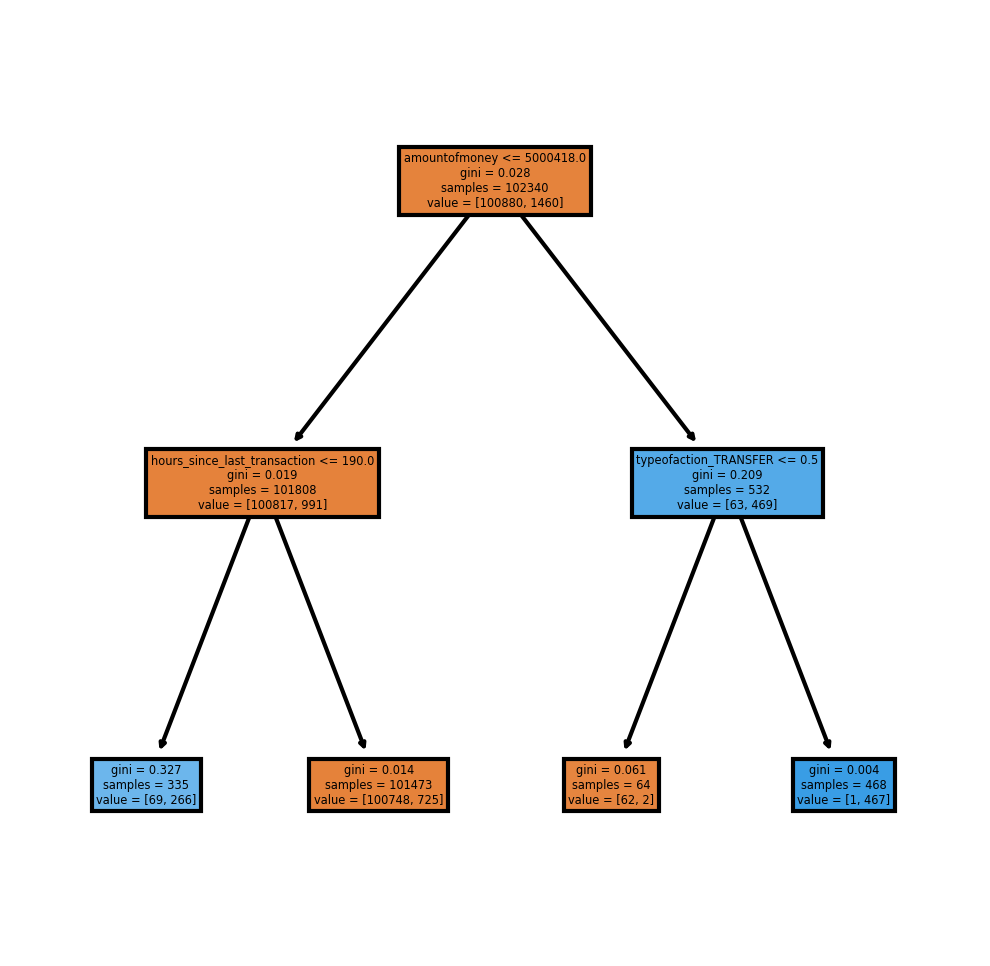

In [21]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_tree2,
               feature_names = fn, 
               filled = True);

### Random Forest

In [23]:
# class balanced random forest for imbalanced classification
rf_model = RandomForestClassifier(class_weight='balanced_subsample')
print('Acc:', cross_val_score(rf_model, X_train, y_train, 
                              cv=StratifiedKFold(n_splits=5), 
                              scoring='accuracy').mean())
print('F1:', cross_val_score(rf_model, X_train, y_train, 
                             cv=StratifiedKFold(n_splits=5), 
                             scoring='f1').mean())
print('ROC AUC:', cross_val_score(rf_model, X_train, y_train, 
                                  cv=StratifiedKFold(n_splits=5), 
                                  scoring='roc_auc').mean())

Acc: 0.9959937344446967
F1: 0.8484611335948621
ROC AUC: 0.9886372783898597


In [24]:
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)
probs_rf = rf_model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probs_rf))

0.9725977229904994


In [31]:
X.columns = ['amountofmoney', 'typeofaction_CASH_OUT', 'typeofaction_DEBIT',
       'typeofaction_PAYMENT', 'typeofaction_TRANSFER',
       'days_since_last_transaction', 'hours_since_last_transaction',
       'transaction_isweekend', 'transaction_isWeekday', 'transaction_isleapyear',
       'prefix_destination_2', 'prefix_destination_3', 'prefix_destination_4',
       'prefix_destination_5', 'prefix_destination_6', 'prefix_destination_7',
       'prefix_destination_8', 'prefix_destination_9', 'prefix_destination_C',
       'prefix_destination_M', 'transaction_month_3', 'transaction_month_4', 'transaction_month_5',
       'transaction_month_6', 'transaction_month_7', 'transaction_day_2', 'transaction_day_3',
       'transaction_day_4', 'transaction_day_5', 'transaction_day_6', 'transaction_day_7', 'transaction_day_8',
       'transaction_day_9', 'transaction_day_10', 'transaction_day_11', 'transaction_day_12',
       'transaction_day_13', 'transaction_day_14', 'transaction_day_15', 'transaction_day_16',
       'transaction_day_17', 'transaction_day_18', 'transaction_day_19', 'transaction_day_20',
       'transaction_day_21', 'transaction_day_22', 'transaction_day_23', 'transaction_day_24',
       'transaction_day_25', 'transaction_day_26', 'transaction_day_27', 'transaction_day_28',
       'transaction_day_29', 'transaction_day_30', 'transaction_day_31', 'transaction_week_9',
       'transaction_week_10', 'transaction_week_11', 'transaction_week_12', 'transaction_week_13',
       'transaction_week_14', 'transaction_week_15', 'transaction_week_16', 'transaction_week_17',
       'transaction_week_18', 'transaction_week_19', 'transaction_week_20', 'transaction_week_21',
       'transaction_week_22', 'transaction_week_23', 'transaction_week_24', 'transaction_week_25',
       'transaction_week_26', 'transaction_week_27', 'transaction_week_28', 'transaction_week_29',
       'transaction_dayofweek_1', 'transaction_dayofweek_2', 'transaction_dayofweek_3',
       'transaction_dayofweek_4', 'transaction_dayofweek_5', 'transaction_dayofweek_6',
       'transaction_quarter_2', 'transaction_quarter_3']

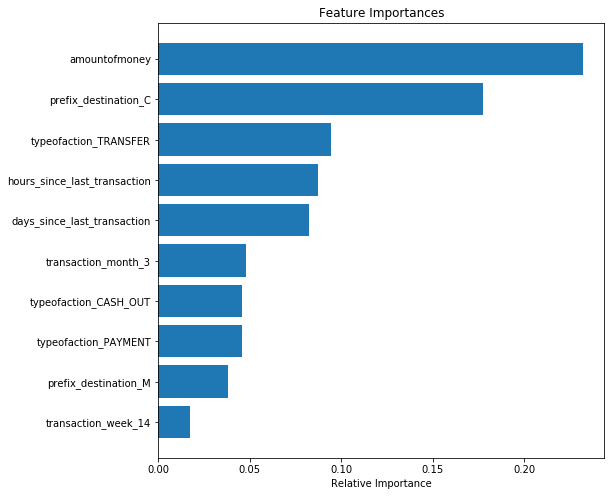

In [35]:
features = X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)
top_20_indices = indices[-10:]
plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(top_20_indices)), importances[top_20_indices], align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()

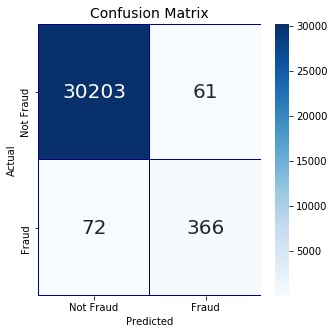

In [33]:
cm = pd.crosstab(y_test, pred_rf, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,annot_kws={"size": 20}, 
            ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='d')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [34]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X.values,
                                                   feature_names=X.columns.to_list(),
                                                   class_names=['normal', 'fraud'],
                                                   verbose=True, mode='classification')

predict_fn = lambda x: rf_model.predict_proba(x).astype(float)
exp = explainer.explain_instance(X.values[0], predict_fn, num_features=10)
exp.show_in_notebook(show_table=True)

Intercept 0.42413759237752785
Prediction_local [0.28094962]
Right: 0.28
